In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings('default')

In [3]:

## Set up the problem
PAR = XNLdyn.XNLpars()

N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_J = 1e-13# J


PAR.N_photens = 5
PAR.t0_i       = [1,0,0,0,0]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [1,1,1,1,1]  # Rms pulse duration / fs
PAR.E_i_abs    = [848,851,852,853,854] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (10,10,10,10,10)


PAR.I0_i =  [1* XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J,
            1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J,
            1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J]

print(*zip(PAR.E_i_abs,PAR.I0_i))


(848, 736.0270134977316) (851, 733.4323236734152) (852, 732.5714876127656) (853, 732.5714876127656) (854, 732.5714876127656)


In [4]:
sim = XNLdyn.XNLsim(PAR, DEBUG=False)#, load_tables = False

sim.par.I0_i

Energy 0.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 1.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 1.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 2.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 2.30 too close to others to satisfy the resonant bandwidth of 0.80
Energy 3.30 too close to others to satisfy the resonant bandwidth of 0.80


[736.0270134977316,
 733.4323236734152,
 732.5714876127656,
 732.5714876127656,
 732.5714876127656]

<IPython.core.display.Javascript object>


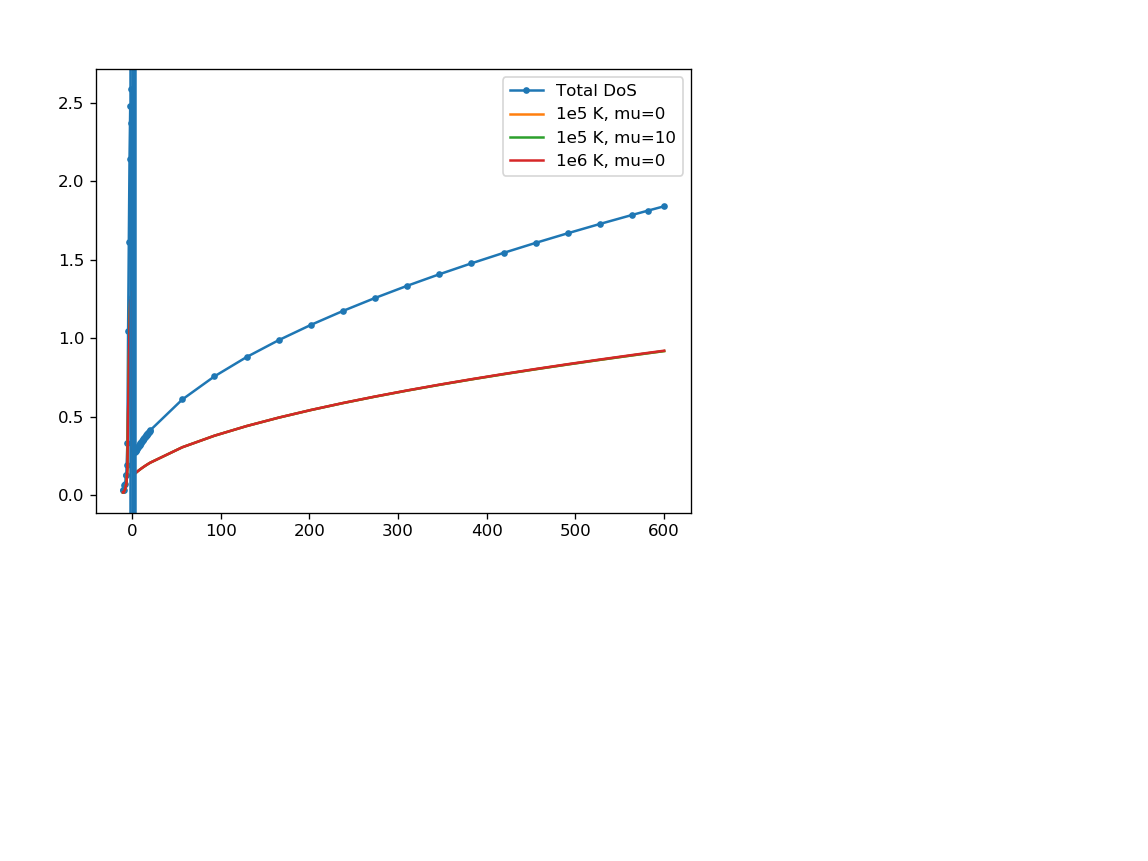

In [5]:
plt.figure()
plt.plot(PAR.E_j,PAR.m_j/PAR.enax_dE_j,'.-', label ='Total DoS')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,0)*PAR.m_j/PAR.enax_dE_j, label = '1e5 K, mu=0')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,10)*PAR.m_j/PAR.enax_dE_j, label = '1e5 K, mu=10')
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e6,0)*PAR.m_j/PAR.enax_dE_j, label = '1e6 K, mu=0')
plt.legend()
for ei in PAR.E_i:
    plt.axvline(ei)

In [6]:
PAR.m_j[PAR.resonant]

array([1.71621638, 1.13412527, 0.29209879, 0.29209879, 0.24462903])

<IPython.core.display.Javascript object>


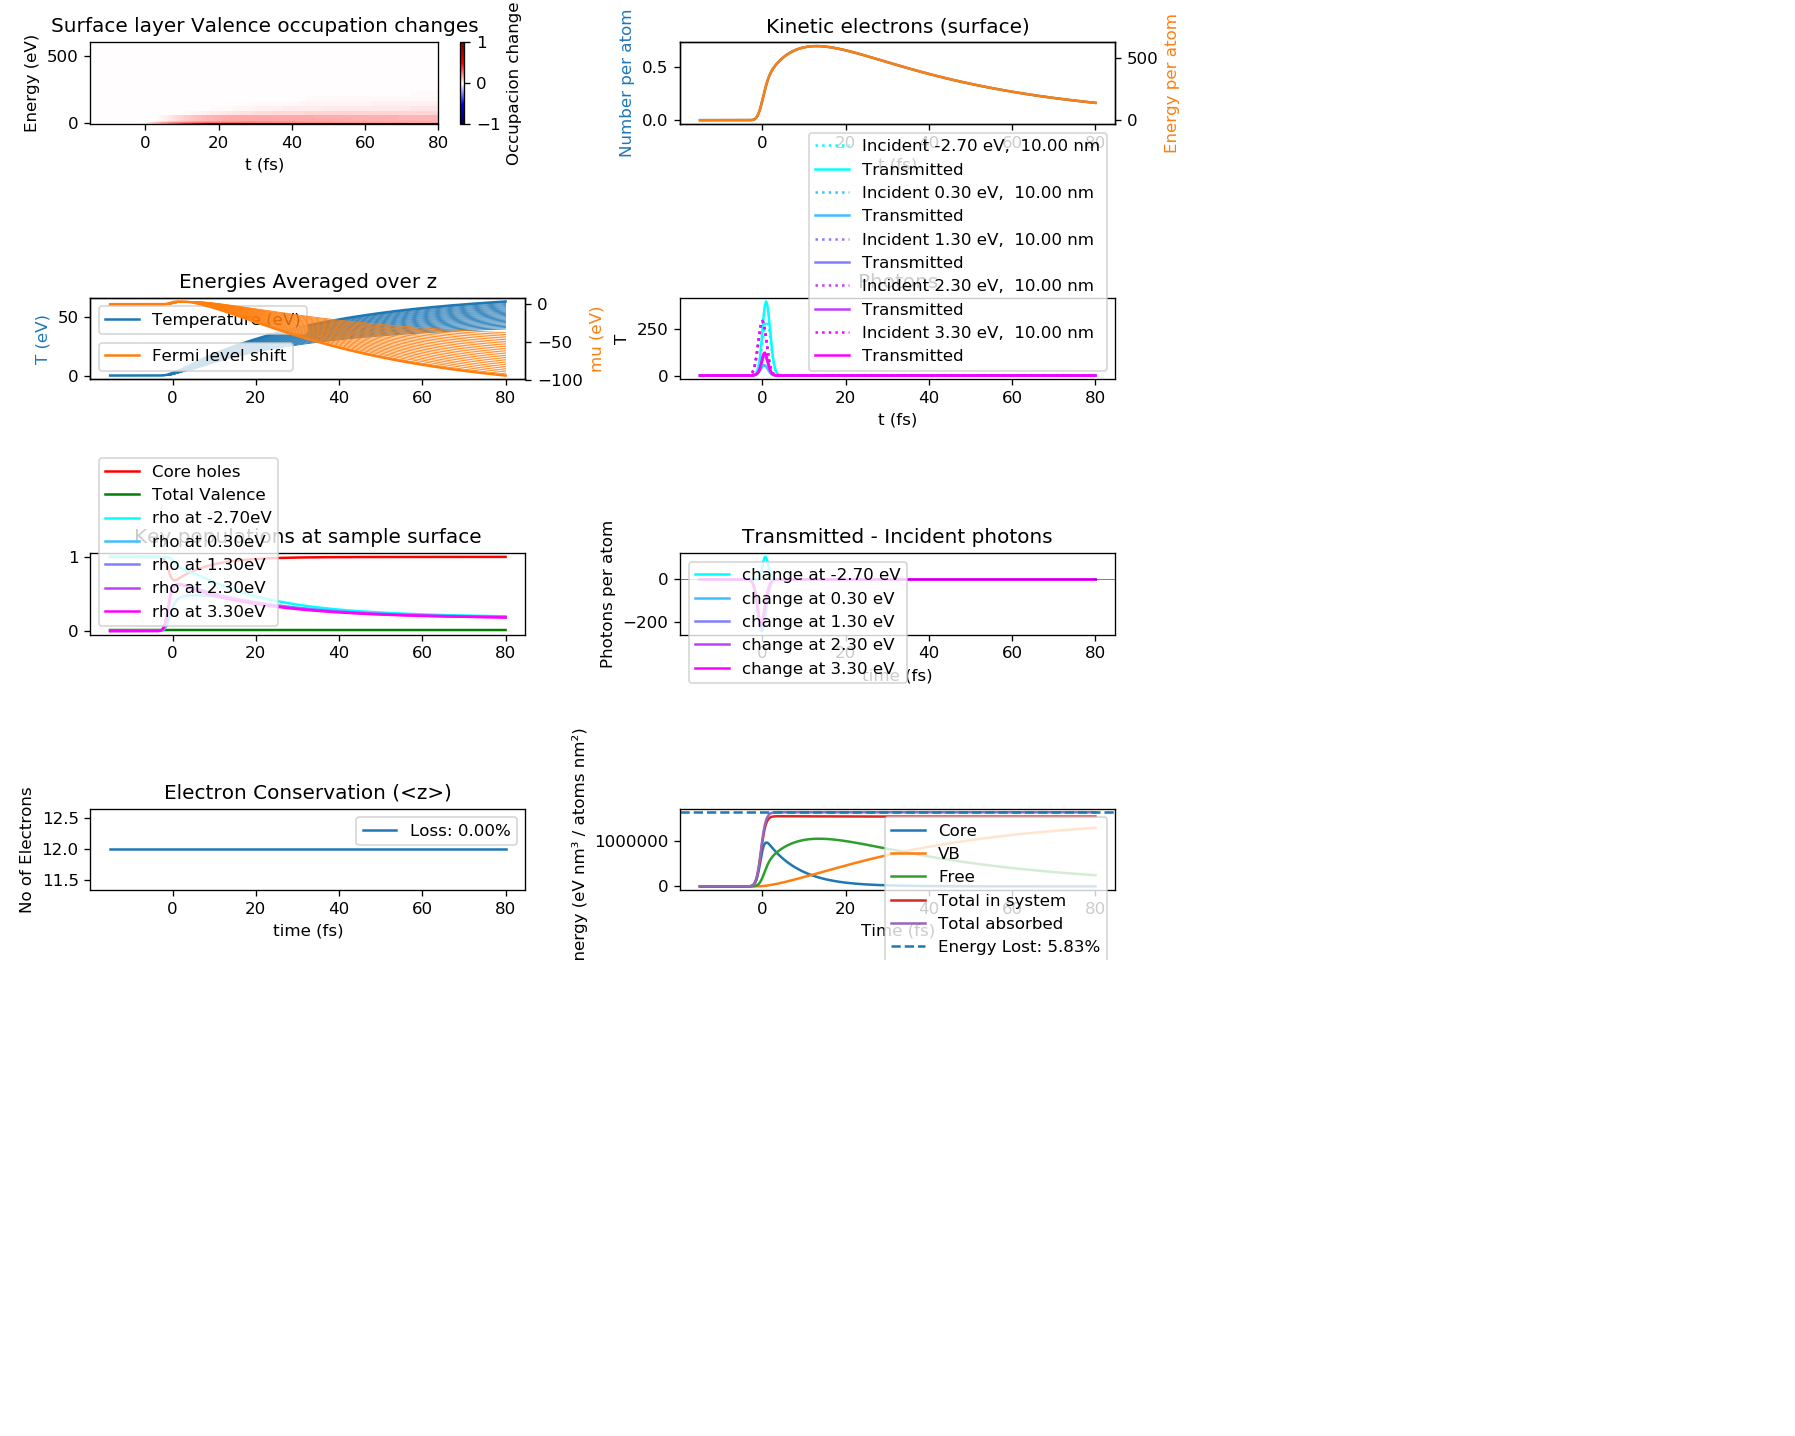

Done
Transmission:  [126.07942168  16.60260925  30.8069495   29.54425313  33.08118475]  %
CPU times: user 6min 25s, sys: 34min 26s, total: 40min 51s
Wall time: 51.9 s


In [8]:
%%time
sim_options = dict(t_span=[-15, 80],
                   method='RK45',
                   rtol=1e-5, atol=1e-8, 
                   plot = True,
                   return_full_solution = True)

incident, transmitted, sol = sim.run(**sim_options)

print('Transmission: ', 100 * transmitted/incident, ' %')


<IPython.core.display.Javascript object>


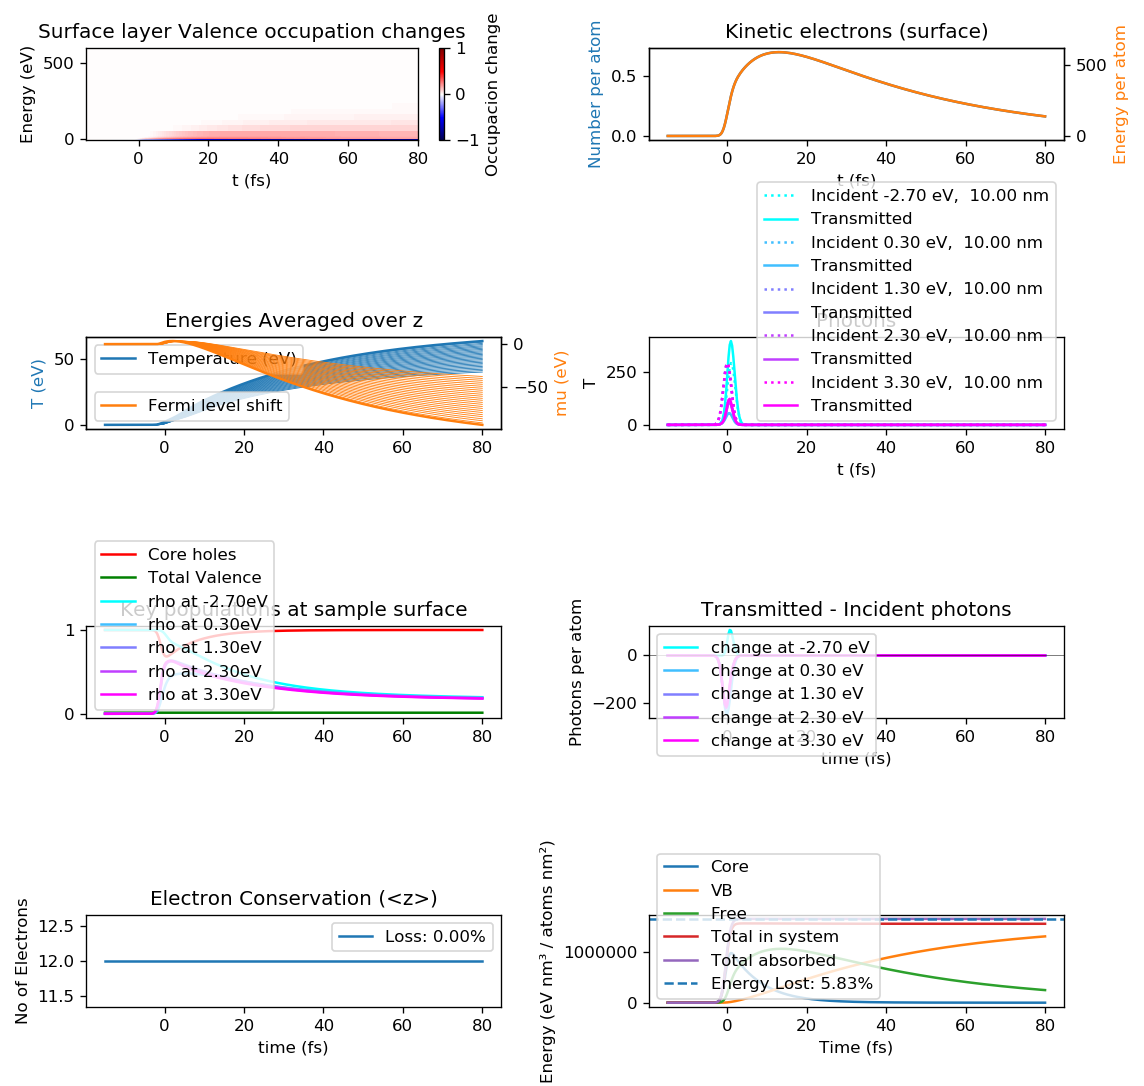

Done


In [9]:

sim.plot_results(sol, sol.photon_densities)

### Calculate inner energies and temperatures in the VB

In [10]:
self = sim
inner_energies = np.zeros((len(sol.t),self.par.Nsteps_z))
for it, t in enumerate(sol.t):
    for iz in range(self.par.Nsteps_z):
        U = np.sum(sol.rho_j[iz, :, it] * self.par.E_j)
        R = sol.R_VB[iz, it]
        T, mu_chem = self.par.FermiSolver.solve(U, R)
        if np.isnan(T):
            T, mu_chem = self.par.FermiSolver.save_lookup_Tmu_from_UR(U, R)
        # if self.DEBUG and (iz==0):
        #    print(U,R,'->',T, mu_chem)
        sol.temperatures[it, iz], sol.chemical_potentials[it, iz] = (T, mu_chem)
        inner_energies[it,iz] = U # This is needed later to check the energy conservation

### Calculate Total energy in the stack

In [11]:

## Integrat energy for each timestepsol.chemical_potentials+
absorbed_energy_dt = np.sum((sol.photon_densities[0]-sol.photon_densities[-1]).T*(self.par.E_i+self.par.E_f),1)
absorbed_energy = np.array([np.trapz(absorbed_energy_dt[:i+1],sol.t[:i+1]) for i in range(len(absorbed_energy_dt))])

factor = self.par.atomic_density * self.par.zstepsize # From energy per atom to energy per nm²
total_free = np.sum(sol.E_free[:,:],0) * factor#*1.01
#total_free_simple = np.sum(sol.R_free[:,:]*(self.par.E_f),0) * factor
total_inner = (np.sum(inner_energies[:,:],1)-np.sum(inner_energies[0,:])) * factor#*0.9
#total_inner = total_inner - total_inner[0]
total_core = np.sum((self.par.M_core- sol.core[:,:])*self.par.E_f,0) * factor#*1.13
#total_core = np.sum(self.par.M_core * (self.par.M_core/sol.core[:,:])*self.par.E_f,0) * factor

total_energies = total_free + total_inner + total_core
#total_energies_simple = total_free_simple + total_inner + total_core


<IPython.core.display.Javascript object>


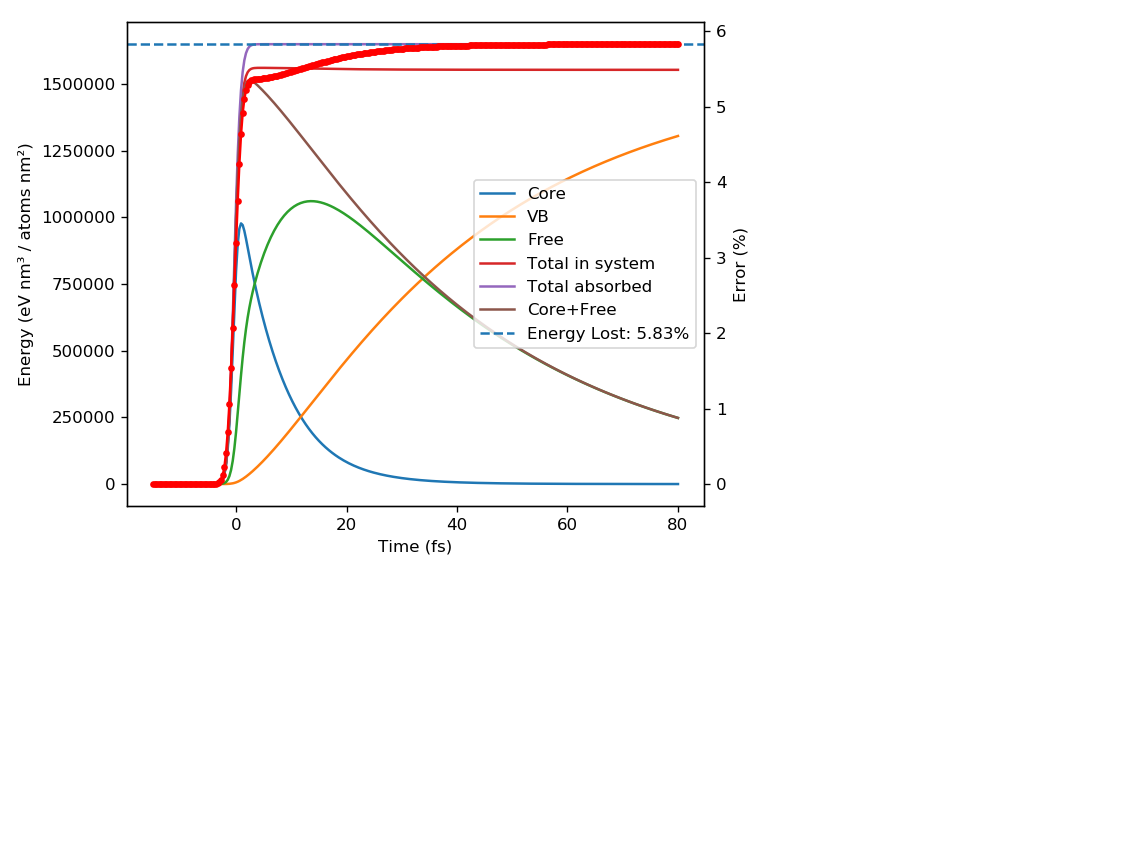

Done


In [12]:

plt.figure()
ax1 = plt.gca()
plt.plot(sol.t, total_core, label = 'Core')
plt.plot(sol.t, total_inner, label = 'VB')
plt.plot(sol.t, total_free, label = 'Free')
#plt.plot(sol.t, total_free_simple, label = 'Free simple')
plt.plot(sol.t, total_energies, label = 'Total in system')
#plt.plot(sol.t, total_energies_simple, label = 'Total in system simple')
plt.plot(sol.t, absorbed_energy, label = 'Total absorbed')

plt.plot(sol.t, total_free+total_core, label = 'Core+Free')



plt.axhline(absorbed_energy[-1], ls='--', label=f'Energy Lost: {100*(absorbed_energy[-1]-total_energies[-1])/absorbed_energy[-1]:.2f}%')
plt.legend()

plt.xlabel('Time (fs)')
plt.ylabel('Energy (eV nm³ / atoms nm²)')

ax2 = ax1.twinx()
err = np.abs(absorbed_energy-total_energies)/np.max(absorbed_energy)
#err[absorbed_energy< 1e-2*np.max(absorbed_energy)]=0
ax2.plot(sol.t, 100*err, '.-', color='red')
ax2.set_ylabel('Error (%)')

plt.tight_layout()
plt.show()
#plt.pause(20)

print('Done')

### Calculate total energy z-resolved

In [13]:
absorbed_energy_dt_dz = np.zeros((PAR.zaxis.shape[0], len(sol.t)))
for i in range(PAR.zaxis.shape[0]):
    absorbed_energy_dt_dz[i] = np.sum((sol.photon_densities[i]-sol.photon_densities[i+1]).T*(self.par.E_i+self.par.E_f),1)
absorbed_energy_dz = np.array([np.trapz(absorbed_energy_dt_dz[:,:i+1],sol.t[:i+1],0) for i in range(absorbed_energy_dt_dz.shape[1])])


factor = self.par.atomic_density * self.par.zstepsize # From energy per atom to energy per nm²
total_free_dz = (sol.E_free[:,:] * factor).T

total_inner_dz = (inner_energies[:,:]-inner_energies[0,:]) * factor

total_core_dz = ((self.par.M_core- sol.core[:,:])*self.par.E_f * factor).T


total_energies_dz = total_free_dz + total_inner_dz + total_core_dz
#total_energies_simple = total_free_simple + total_inner + total_core

In [14]:
total_core_dz.shape

(324, 150)

<IPython.core.display.Javascript object>


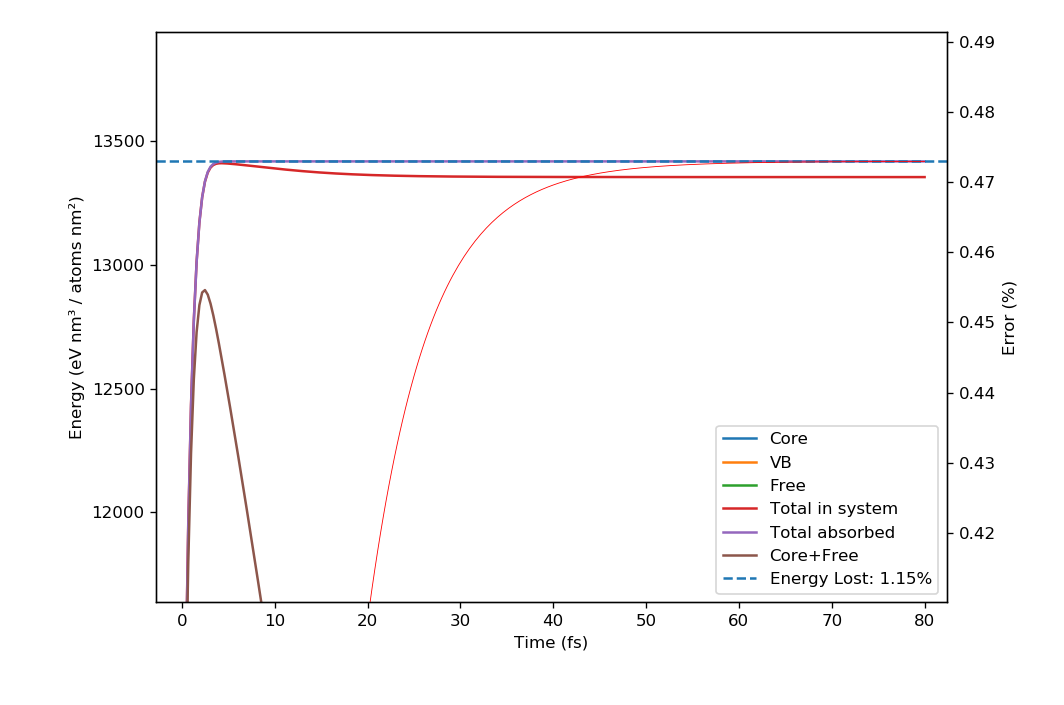

Done


In [15]:
plotz = np.s_[:,10]

plt.figure(figsize =(6,4))
ax1 = plt.gca()
plt.plot(sol.t, total_core_dz[plotz], label = 'Core')
plt.plot(sol.t, total_inner_dz[plotz], label = 'VB')
plt.plot(sol.t, total_free_dz[plotz], label = 'Free')
plt.plot(sol.t, total_energies_dz[plotz], label = 'Total in system')
plt.plot(sol.t, absorbed_energy_dz[plotz], label = 'Total absorbed')

plt.plot(sol.t, total_free_dz[plotz]+total_core_dz[plotz], label = 'Core+Free')



plt.axhline(absorbed_energy_dz[plotz][-1], ls='--', label=f'Energy Lost: {100*(absorbed_energy[-1]-total_energies[-1])/absorbed_energy[-1]:.2f}%')
plt.legend()

plt.xlabel('Time (fs)')
plt.ylabel('Energy (eV nm³ / atoms nm²)')

ax2 = ax1.twinx()
err = np.abs(absorbed_energy_dz[plotz]-total_energies_dz[plotz])/np.max(absorbed_energy_dz[plotz])
#err[absorbed_energy< 1e-2*np.max(absorbed_energy)]=0
ax2.plot(sol.t, 100*err,  lw=0.5,color='red')
ax2.set_ylabel('Error (%)')

plt.tight_layout()
plt.show()
#plt.pause(20)

print('Done')

In [12]:
### calculate rates

it = 50
t = sol.t[it]

all_changes = np.zeros((len(sol.t), PAR.Nsteps_z, PAR.states_per_voxel))

for it, t in enumerate(sol.t):
    photons = np.zeros((PAR.Nsteps_z, PAR.N_j))
    photons[:,PAR.resonant] = sol.photon_densities[:-1,:,it]
    states = sol.y[:,it].reshape(PAR.Nsteps_z, PAR.states_per_voxel)
    rj_z = np.zeros((PAR.Nsteps_z, PAR.N_j))
    for iz in range(PAR.Nsteps_z):
        rj_z[iz,:] = PAR.FermiSolver.fermi(sol.temperatures[it,iz], sol.chemical_potentials[it,iz]) * PAR.m_j
    res_inter, nonres_inter, ch_decay, el_therm, el_scatt, en_free = sim.calc_processes(photons , states, rj_z)

    all_changes[it,:, 0] = sim.rate_core(res_inter, ch_decay)
    all_changes[it,:, 1] = sim.rate_free(nonres_inter, ch_decay, el_scatt)
    all_changes[it,:, 2] = sim.rate_E_free(nonres_inter, ch_decay, el_scatt)
    all_changes[it,:, 3:] = sim.rate_j(res_inter,nonres_inter,ch_decay,el_therm,el_scatt)
    
core_changes = all_changes[:,:,0]
free_changes = all_changes[:,:,1]
efree_changes = all_changes[:,:,2]
j_changes = all_changes[:,:,3:]


Deviation from energy conservation (%):  29.383288833112974
Deviation from energy conservation (%):  0.0036108428198634943
Deviation from energy conservation (%):  4.656025189284645e-06
Deviation from energy conservation (%):  3.9317147413758157e-07
Deviation from energy conservation (%):  2.3518379026374788e-07
Deviation from energy conservation (%):  2.722857447373081e-08
Deviation from energy conservation (%):  1.1452827454356233e-08


In [17]:
def plot_conservations(self, sol):
    """
    Plot Energy and electron conservations. Call after plot_results()
    """
    PAR = self.par
    all_changes = np.zeros((len(sol.t), PAR.Nsteps_z, PAR.states_per_voxel))

    for it, t in enumerate(sol.t):
        photons = np.zeros((PAR.Nsteps_z, PAR.N_j))
        photons[:,PAR.resonant] = sol.photon_densities[:-1,:,it]
        states = sol.y[:,it].reshape(PAR.Nsteps_z, PAR.states_per_voxel)
        rj_z = np.zeros((PAR.Nsteps_z, PAR.N_j))
        for iz in range(PAR.Nsteps_z):
            rj_z[iz,:] = PAR.FermiSolver.fermi(sol.temperatures[it,iz], sol.chemical_potentials[it,iz]) * PAR.m_j
        res_inter, nonres_inter, ch_decay, el_therm, el_scatt, en_free = sim.calc_processes(photons , states, rj_z)

        all_changes[it,:, 0] = sim.rate_core(res_inter, ch_decay)
        all_changes[it,:, 1] = sim.rate_free(nonres_inter, ch_decay, el_scatt)
        all_changes[it,:, 2] = sim.rate_E_free(nonres_inter, ch_decay, el_scatt)
        all_changes[it,:, 3:] = sim.rate_j(res_inter,nonres_inter,ch_decay,el_therm,el_scatt)

    core_changes = all_changes[:,:,0]
    free_changes = all_changes[:,:,1]
    efree_changes = all_changes[:,:,2]
    j_changes = all_changes[:,:,3:]


In [18]:
U_changes = np.sum(j_changes*PAR.E_j,2) # this is just the derivative at each point
U_changes_actual = np.gradient(sol.inner_energies,sol.t, axis = 0)# This is the actual change, which is different due to RK45

NameError: name 'j_changes' is not defined

<IPython.core.display.Javascript object>


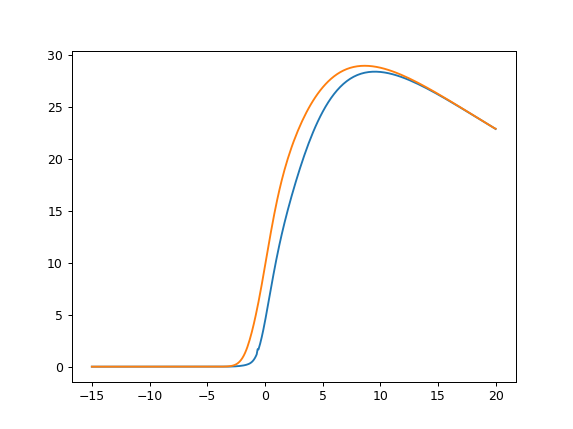

In [15]:
plt.figure()
#plt.plot(sol.t,core_changes[:,0])
#plt.plot(sol.t,free_changes[:,0])
plt.plot(sol.t,U_changes[:,0])
plt.plot(sol.t[:],U_changes_actual[:,0])

#plt.plot(sol.t,j_changes[:,0][:,PAR.resonant])

<IPython.core.display.Javascript object>


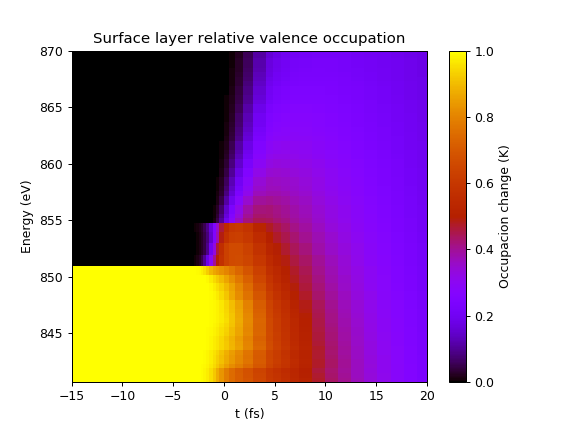

(840.7, 870)

In [21]:
plt.figure()
plt.pcolormesh(sol.t, PAR.E_j +PAR.E_f,
               (sol.rho_j[0])/np.outer(PAR.m_j,np.ones(sol.t.shape)),
               cmap = plt.cm.gnuplot, vmin = 0, vmax = 1, shading = 'nearest')#
plt.colorbar(label = 'Occupacion change (K)')
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer relative valence occupation')
plt.ylim(None, 870)

<IPython.core.display.Javascript object>


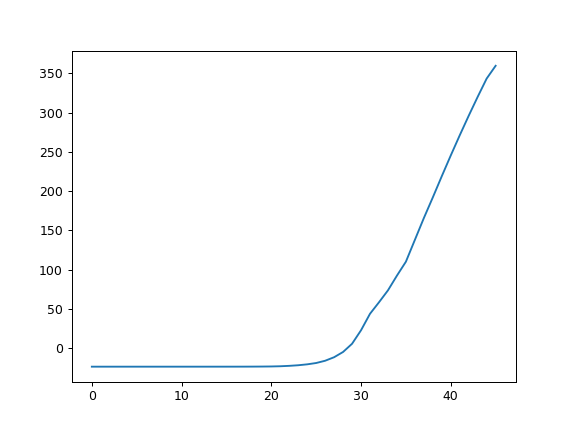

In [28]:
plt.figure()
plt.plot(sol.inner_energies[:,0])

<IPython.core.display.Javascript object>


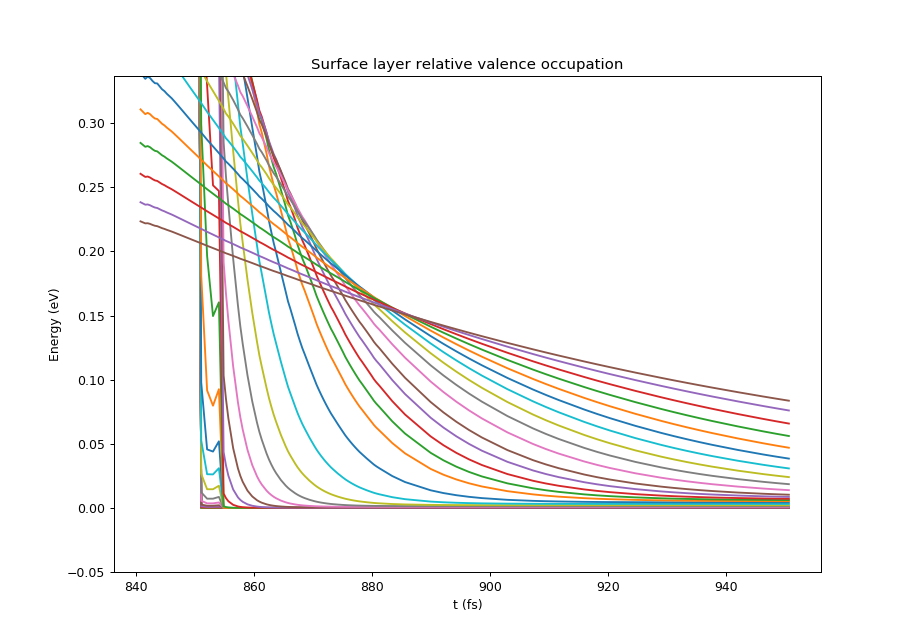

Text(0.5, 1.0, 'Surface layer relative valence occupation')

In [25]:
plt.figure()
plt.plot(PAR.E_j +PAR.E_f,
               (sol.rho_j[0])/np.outer(PAR.m_j,np.ones(sol.t.shape)))#
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer relative valence occupation')


<IPython.core.display.Javascript object>


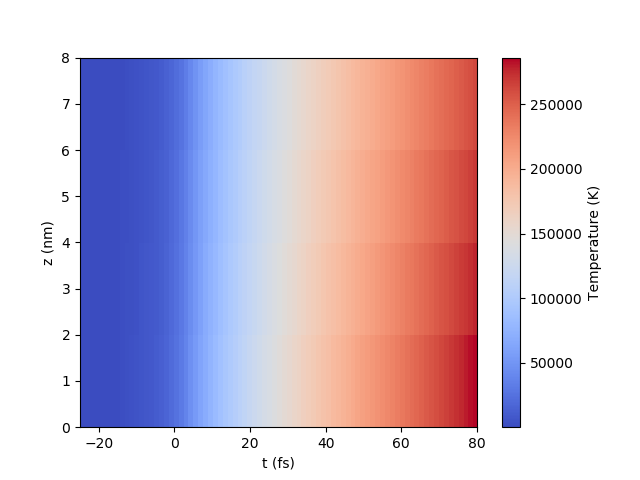

Text(0, 0.5, 'z (nm)')

In [14]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.temperatures.T, cmap = plt.cm.coolwarm)
plt.colorbar(label = 'Temperature (K)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


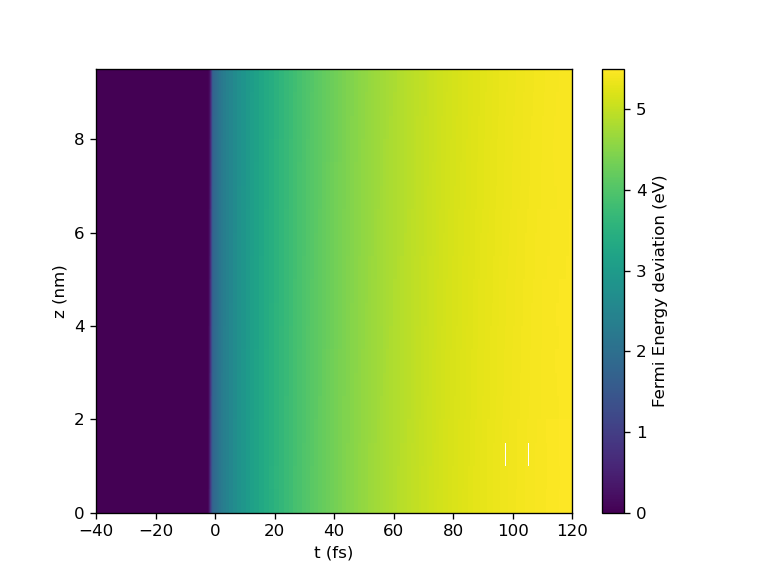

/tmp/ipykernel_186854/203480434.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)


Text(0, 0.5, 'z (nm)')

In [35]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)
plt.colorbar(label = 'Fermi Energy deviation (eV)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


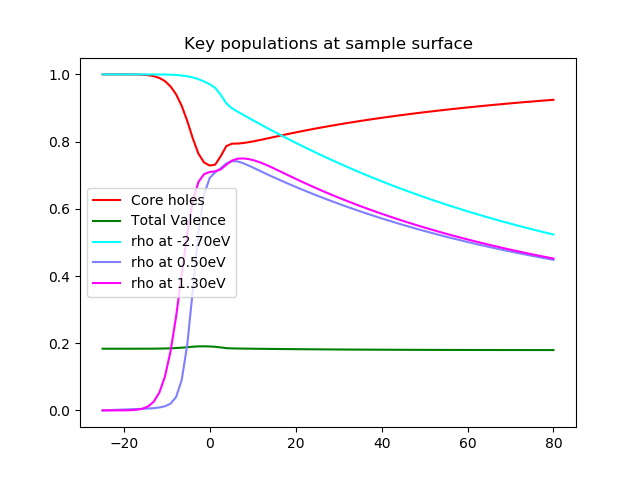

In [15]:
plt.figure()
plt.title('Key populations at sample surface')
plt.plot(sol.t,sol.core[0]/PAR.M_core, c='red', label = 'Core holes')
plt.plot(sol.t,(sol.R_VB[0])/PAR.M_VB, c='green',label = 'Total Valence')
cols = plt.cm.cool(np.linspace(0,1,PAR.N_photens))
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,sol.rho_j[0,PAR.resonant,:][iE].T/PAR.m_j[PAR.resonant][iE],c = cols[iE], label = f'rho at {E:.2f}eV')
plt.legend()


<IPython.core.display.Javascript object>


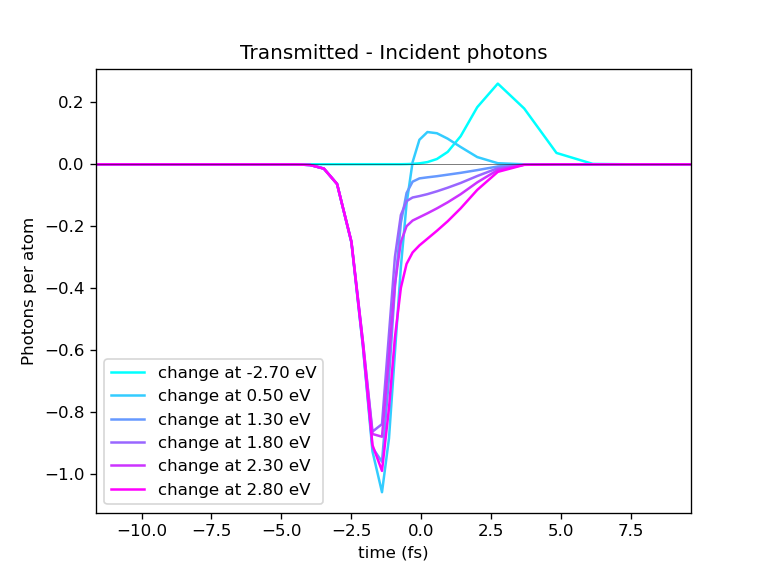

Text(0, 0.5, 'Photons per atom')

In [13]:
T = (sol.photon_densities[-1]-sol.photon_densities[0])#/np.max(sol.photon_densities[0],1)

plt.figure()
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,T[iE],c = cols[iE], label = f'change at {E:.2f} eV')
plt.axhline(c='k', lw = 0.3)
plt.legend()

plt.title('Transmitted - Incident photons')
plt.xlabel('time (fs)')
plt.ylabel('Photons per atom')

In [24]:
PAR.M_core

2

<IPython.core.display.Javascript object>


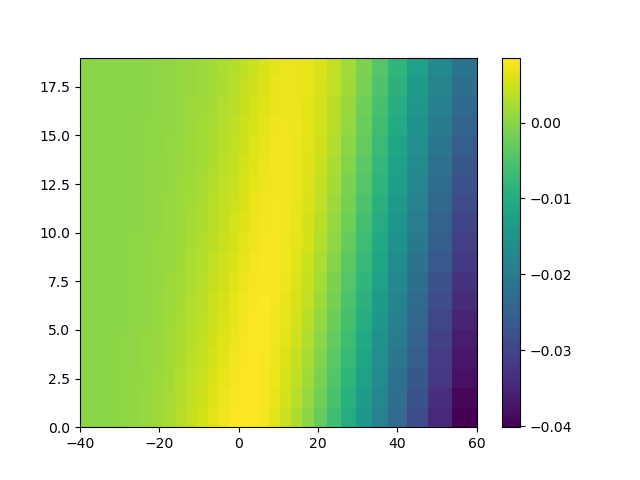

/tmp/ipykernel_121456/52012410.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)


In [34]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)
plt.colorbar()

In [21]:
sol.t.shape

(40,)

In [77]:
def make_valence_energy_axis(self, N_j: int, min=-6, finemax=10, max=50):
        """
        Creates an energy axis for the valence band, namely
            self.E_j
        and its edgepoints
            self.enax_j_edges
        Energies are relative to the fermi-level. 3/4 of all points fall into the range (min, finemax)
        Makes sure that the energies E_i correspond to a point in E_j and
        drops the closest points to keep the number N_j.
        :param N_j:
        :param min:
        :param finemax:
        :param max:
        :return:
        """
        N_j_fine = int(N_j * 3 / 4)
        N_j_coarse = int(N_j - N_j_fine)

        def fill_biggest_gap(pointlist):
            """
            This function takes a list of points and appends a point in the middle of the biggest gap
            """
            pointlist = np.array(np.sort(pointlist))
            gaps = pointlist[1:]-pointlist[:-1]
            biggest_gap_index = np.argsort(gaps)[-1]
            biggest_gap = gaps[biggest_gap_index]
            list_before = pointlist[:biggest_gap_index+1]
            new_value = pointlist[biggest_gap_index] + 0.5*biggest_gap
            list_after = pointlist[biggest_gap_index+1:]
            return np.concatenate((list_before, [new_value,], list_after))
        
        # The energies E_i and 0 must be in the axis
        enax_j_fine = [min, 0, finemax]+list(self.E_i[self.E_i<=finemax])
        # Fill up the gaps
        while len(enax_j_fine)<N_j_fine:
            enax_j_fine = fill_biggest_gap(enax_j_fine)
        
        dE = np.mean(enax_j_fine[1:]-enax_j_fine[:-1])
        #The same for the coarse part
        enax_j_coarse = [finemax+dE, max]+list(self.E_i[self.E_i>finemax])
        while len(enax_j_coarse)<N_j_coarse:
            enax_j_coarse = fill_biggest_gap(enax_j_coarse)
            
        enax_j = np.concatenate((enax_j_fine, enax_j_coarse))

        if not len(enax_j) == N_j:
            warnings.warn(
                'Energy Axis turned out longer or shorter than planned. What went wrong?')
            self.N_j = len(enax_j)
            
        def edgepoints(middles):
            """ Opposite of midpoints """
            edges = np.empty(middles.shape[0] + 1)
            edges[1:-1] = (middles[1:] + middles[:-1]) / 2
            edges[0] = middles[0] - (middles[1] - middles[0]) / 2
            edges[-1] = middles[-1] + (middles[-1] - middles[-2]) / 2
            return edges

        return enax_j, edgepoints(enax_j)

In [55]:
sim.plot_derivatives?

<IPython.core.display.Javascript object>


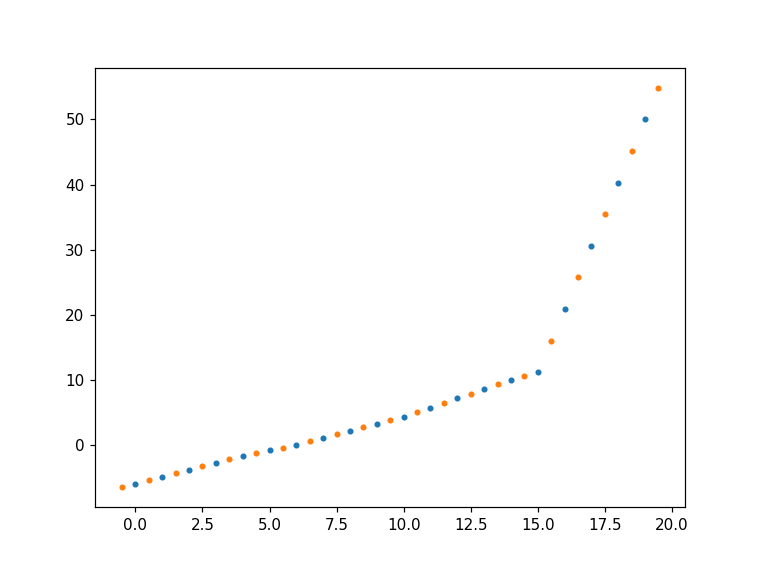

In [82]:
enax, enax_edges = make_valence_energy_axis(PAR, 20, min=-6, finemax=10, max=50)
plt.figure()
plt.plot(np.arange(len(enax)),enax,'.')
plt.plot(np.arange(len(enax_edges))-0.5,enax_edges,'.')